<a href="https://colab.research.google.com/github/aabdysheva/collab-files/blob/main/CNN_cat_dogs_(keras).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import random
import glob
import shutil
import os

from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model

from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import mobilenet
from tensorflow.keras.applications import imagenet_utils

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

from sklearn.metrics import confusion_matrix

%matplotlib inline

# image data preprocessing

In [ ]:
import os 
directory = os.path.dirname(os.path.realpath('PetImages'))

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip -q kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   191M      0  0:00:04  0:00:04 --:--:--  191M
replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
directory = '/content/PetImages'

In [ ]:
tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode="int",
    class_names=['Cat', 'Dog'],
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False)

Found 19701 files belonging to 2 classes.


<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
train_path = 'train'
valid_path = 'valid'
test_path = 'test'

if os.path.isdir('train/cat') is False:
    os.makedirs(train_path + '/dog')
    os.makedirs(train_path + '/cat')
    os.makedirs(valid_path + '/dog')
    os.makedirs(valid_path + '/cat')
    os.makedirs(test_path + '/dog')
    os.makedirs(test_path + '/cat')

In [ ]:
def move_files(source, dest, n_of_files):
    files = os.listdir(source)
    for file_name in random.sample(files, n_of_files):
        shutil.move(os.path.join(source, file_name), dest)

In [ ]:
move_files('PetImages/Cat/','train/cat/', 1000)
move_files('PetImages/Dog/','train/dog/', 1000)
move_files('PetImages/Cat/', 'valid/cat/', 1000)
move_files('PetImages/Dog/', 'valid/dog/', 500)
move_files('PetImages/Cat/', 'test/cat/', 500)
move_files('PetImages/Dog/', 'test/dog/', 500)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_path = 'train'
valid_path = 'valid'
test_path = 'test'

train_batches = ImageDataGenerator(rescale=1/225).flow_from_directory(directory=train_path, 
                                          target_size=(224,224), 
                                          classes=['cat', 'dog'],
                                          batch_size=32)

valid_batches = ImageDataGenerator(rescale=1/225).flow_from_directory(directory=valid_path, 
                                      target_size=(224,224), 
                                      classes=['cat', 'dog'], 
                                      batch_size=32)

test_batches = ImageDataGenerator(rescale=1/225).flow_from_directory(directory=test_path, 
                                     target_size=(224,224), 
                                     classes=['cat', 'dog'], 
                                     batch_size=32, 
                                     shuffle=False)

Found 2500 images belonging to 2 classes.
Found 1700 images belonging to 2 classes.
Found 1099 images belonging to 2 classes.


### Plot images func

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

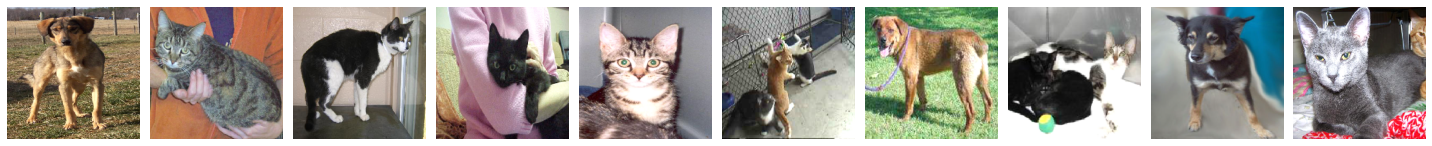

In [ ]:
imgs, labels = next(train_batches);
np.rollaxis(imgs, 3, 3)  
plotImages(imgs);

# Autoencoder

In [ ]:
from keras import layers

In [ ]:
train_batches[0][0].shape
len(train_batches)

79

In [ ]:
encoding_dim = 32

input_img = keras.Input(shape=(2500,))

encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
decoded = layers.Dense(2500, activation='sigmoid')(encoded)
autoencoder = keras.Model(input_img, decoded)
encoder = keras.Model(input_img, encoded)

encoded_input = keras.Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

#train
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels=None,
    label_mode=None,
    class_names=['Cat', 'Dog'],
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False)

In [ ]:
train_batches = ImageDataGenerator(rescale=1/225).flow_from_directory(directory=train_path, 
                                          target_size=(224,224), 
                                          classes=['cat', 'dog'],
                                          batch_size=32)

valid_batches = ImageDataGenerator(rescale=1/225).flow_from_directory(directory=valid_path, 
                                      target_size=(224,224), 
                                      classes=['cat', 'dog'], 
                                      batch_size=32)

test_batches = ImageDataGenerator(rescale=1/225).flow_from_directory(directory=test_path, 
                                     target_size=(224,224), 
                                     classes=['cat', 'dog'], 
                                     batch_size=32, 
                                     shuffle=False)

In [ ]:
autoencoder.fit(train_batches, train_batches, epochs=100, batch_size=256,
                shuffle=True, validation_data = valid_batches)

Epoch 1/100


InvalidArgumentError: ignored

# Model

In [ ]:
input_shape = (224,224,3)
num_classes = 2

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Flatten(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='sigmoid'),
    ])

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 109, 109, 32)      18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 93312)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 93312)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
             loss="binary_crossentropy",
             metrics=['accuracy'])

model.fit(x=train_batches,
         validation_data=valid_batches,
         epochs=8,
         verbose=2)

Epoch 1/8
100/100 - 80s - loss: 18.0167 - accuracy: 0.5020 - val_loss: 0.6920 - val_accuracy: 0.5150
Epoch 2/8
100/100 - 78s - loss: 0.6887 - accuracy: 0.5200 - val_loss: 0.6920 - val_accuracy: 0.5200
Epoch 3/8
100/100 - 77s - loss: 0.6601 - accuracy: 0.5810 - val_loss: 0.6921 - val_accuracy: 0.5100
Epoch 4/8
100/100 - 77s - loss: 0.6273 - accuracy: 0.6260 - val_loss: 0.9270 - val_accuracy: 0.5000
Epoch 5/8
100/100 - 76s - loss: 0.5454 - accuracy: 0.7050 - val_loss: 1.0563 - val_accuracy: 0.4650
Epoch 6/8
100/100 - 78s - loss: 0.4417 - accuracy: 0.7730 - val_loss: 1.0241 - val_accuracy: 0.5050
Epoch 7/8
100/100 - 76s - loss: 0.3626 - accuracy: 0.8260 - val_loss: 1.6516 - val_accuracy: 0.4900
Epoch 8/8
100/100 - 79s - loss: 0.3247 - accuracy: 0.8500 - val_loss: 1.6065 - val_accuracy: 0.4700


In [ ]:
y_pred = model.predict(test_batches)
y_pred

array([[4.9600956e-01, 5.0390798e-01],
       [7.8808171e-01, 1.7714316e-01],
       [4.2202643e-01, 4.9695200e-01],
       [4.3807611e-01, 6.0260385e-01],
       [9.0146482e-01, 9.6137941e-02],
       [5.5076647e-01, 5.3471696e-01],
       [5.7571906e-01, 3.8446385e-01],
       [5.2569413e-01, 5.0700963e-01],
       [5.7877046e-01, 4.8742205e-01],
       [2.8008348e-01, 7.2390980e-01],
       [4.0308872e-01, 7.3539281e-01],
       [9.7692448e-01, 2.2740662e-02],
       [3.6110502e-01, 6.3252270e-01],
       [4.9247861e-02, 9.7585523e-01],
       [7.9896182e-01, 1.7985585e-01],
       [8.9706600e-02, 9.4175434e-01],
       [3.9954457e-01, 5.8751196e-01],
       [6.3593650e-01, 4.0145594e-01],
       [3.7510955e-01, 5.6335038e-01],
       [3.0442739e-01, 6.9654441e-01],
       [5.0552696e-01, 5.0319439e-01],
       [6.1751366e-01, 4.0146121e-01],
       [3.2818168e-01, 6.5713263e-01],
       [3.2230851e-01, 8.0513388e-01],
       [5.1141667e-01, 5.0513393e-01],
       [1.3237485e-01, 8.

In [ ]:
test_batches.reset()
y_pred = model.predict(test_batches)

In [ ]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

In [ ]:
y_pred_classification = np.where(y_pred > 0.5, 1, 0)
y_pred_classification

array([[0, 1],
       [1, 0],
       [0, 0],
       [0, 1],
       [1, 0],
       [1, 1],
       [1, 0],
       [1, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 1],
       [1, 0],
       [1, 0],
       [0, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1,

TypeError: Invalid shape (10, 224, 224, 3) for image data

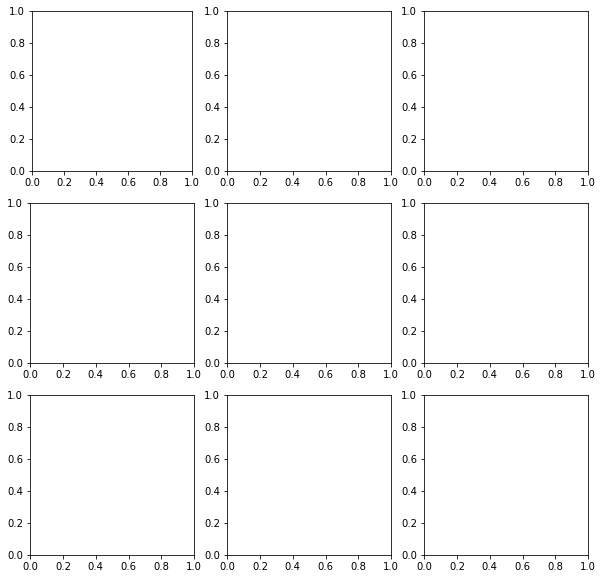

In [ ]:
test_batches.reset()
test_images = test_batches[0][:9]

fig, ax = plt.subplots(3,3)
fig.set_size_inches(10,10)

for i, img in enumerate(test_images):
    ax[i//3][i%3].imshow(img)
    if y_pred_classification[i]==1:
        label = 'Dog'
    else:
        label = 'Cat'
    ax[i//3][i%3].set_title(label)

In [ ]:
import random

def prepareImage(file):
    img = image.load_img(file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    return mobilenet.preprocess_input(np.expand_dims(img_array, axis=0))

def getRandomImageFile():
    return random.sample(glob.glob('test/cat/*'), 1)[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


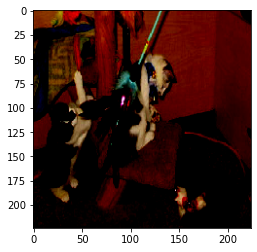

In [ ]:
img = getRandomImageFile()
img_prepared = prepareImage(img).reshape(224,224,3)
plt.imshow(img_prepared)

In [ ]:
pred = model.predict(prepareImage(img))
pred = keras.utils.to_categorical(pred, num_classes)
pred

array([[[1., 0.],
        [1., 0.]]], dtype=float32)

In [ ]:
pred=model.predict(prepareImage(img))
pred

array([[0.4928225, 0.5084929]], dtype=float32)

# MobileNet
**with new set of classes (2)**

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False)

# добавляем свои итоговые слои (классификация на 2 класса)
x = base_model.output
x = GlobalAveragePooling2D()(x)
# add fully-connected layer
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

#model
model = Model(inputs=base_model.input, outputs=predictions)

# train only the top layers
for layer in base_model.layers:
    layer.trainable=False
    
#comlile model
model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])

check_point_path = './best.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = check_point_path,
    monitor = 'val_accuracy',
    save_weights_only=False,
    save_best_only=True,
    verbose=1)

#train model
model_history = model.fit(x=train_batches,
                         validation_data=valid_batches,
                         epochs=13,
                         callbacks = [model_checkpoint],
                         verbose=1)

Epoch 1/13
100/100 [==============================] - 53s 480ms/step - loss: 0.8729 - accuracy: 0.7000 - val_loss: 0.5096 - val_accuracy: 0.7500

Epoch 00001: val_accuracy improved from -inf to 0.75000, saving model to ./best.h5
Epoch 2/13
100/100 [==============================] - 47s 467ms/step - loss: 0.4885 - accuracy: 0.7860 - val_loss: 1.0118 - val_accuracy: 0.6000

Epoch 00002: val_accuracy did not improve from 0.75000
Epoch 3/13
100/100 [==============================] - 49s 492ms/step - loss: 0.4287 - accuracy: 0.7890 - val_loss: 0.5107 - val_accuracy: 0.7150

Epoch 00003: val_accuracy did not improve from 0.75000
Epoch 4/13
100/100 [==============================] - 48s 474ms/step - loss: 0.3606 - accuracy: 0.8380 - val_loss: 0.4527 - val_accuracy: 0.7750

Epoch 00004: val_accuracy improved from 0.75000 to 0.77500, saving model to ./best.h5
Epoch 5/13
100/100 [==============================] - 46s 462ms/step - loss: 0.3004 - accuracy: 0.8690 - val_loss: 0.5601 - val_accuracy:

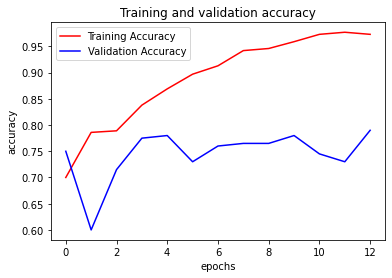

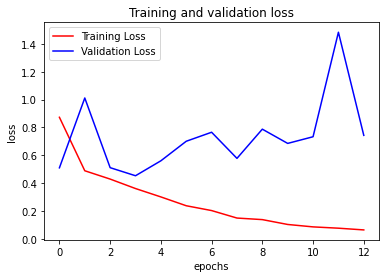

In [ ]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
loss=model_history.history['loss']
val_loss=model_history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(["Training Accuracy","Validation Accuracy"])
plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(["Training Loss","Validation Loss"])
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


собака


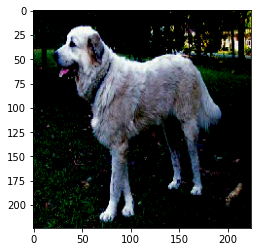

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

def getRandomImageFile():
    return random.sample(glob.glob('test/*/*'), 1)[0]

img_path = getRandomImageFile()
img_prepared = prepareImage(img_path)
# plt.imshow(img_prepared)

# img = image.load_img(img_path, target_size=(224, 224))
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
preds = model.predict(img_prepared)
if np.max(preds) == preds[0,0]:
    print('кот')
else:
    print('собака')
    
plt.imshow(img_prepared.reshape(224,224,3));

# ResNet152V2

In [ ]:
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D


base_model = ResNet152V2(weights='imagenet', include_top=False)

# add pooling (классификация на 2 класса)
x = base_model.output
x = GlobalAveragePooling2D()(x)
# add fully-connected layer
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

#model
model1 = Model(inputs=base_model.input, outputs=predictions)

# train only the top layers
for layer in base_model.layers:
    layer.trainable=False
    
#comlile model
model1.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])

#train model
model1.fit(x=train_batches,
         validation_data=valid_batches,
         epochs=15,
         verbose=2)

Epoch 1/15
100/100 - 351s - loss: 226.3505 - accuracy: 0.4870 - val_loss: 103.6949 - val_accuracy: 0.5400
Epoch 2/15
100/100 - 348s - loss: 54.9574 - accuracy: 0.4920 - val_loss: 5.5335 - val_accuracy: 0.5450
Epoch 3/15
100/100 - 339s - loss: 18.6094 - accuracy: 0.5070 - val_loss: 2.1702 - val_accuracy: 0.5600
Epoch 4/15
100/100 - 358s - loss: 5.0005 - accuracy: 0.5350 - val_loss: 0.6935 - val_accuracy: 0.5100
Epoch 5/15
100/100 - 414s - loss: 0.7609 - accuracy: 0.4950 - val_loss: 0.6931 - val_accuracy: 0.5100
Epoch 6/15
100/100 - 415s - loss: 0.7661 - accuracy: 0.4960 - val_loss: 0.6930 - val_accuracy: 0.5100
Epoch 7/15
100/100 - 391s - loss: 0.7335 - accuracy: 0.5000 - val_loss: 0.6930 - val_accuracy: 0.5100
Epoch 8/15
100/100 - 331s - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6930 - val_accuracy: 0.5100
Epoch 9/15
100/100 - 362s - loss: 0.6932 - accuracy: 0.4940 - val_loss: 0.6930 - val_accuracy: 0.5100
Epoch 10/15
100/100 - 331s - loss: 0.6932 - accuracy: 0.4900 - val_loss: 0.6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cat


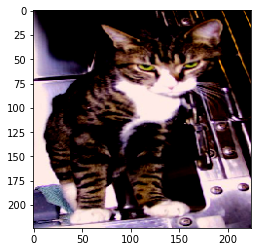

In [ ]:
img_path1 = getRandomImageFile()
img_prepared1 = prepareImage(img_path1)
# plt.imshow(img_prepared)

# img = image.load_img(img_path, target_size=(224, 224))
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
preds1 = model1.predict(img_prepared1)
if np.max(preds1) == preds1[0,0]:
    print('cat')
else:
    print('dog')
    
plt.imshow(img_prepared1.reshape(224,224,3));

In [ ]:
img_path = image.load_img('cat2.JPG', target_size=(224,224))
img_prepared2 = prepareImage(img_path)
preds_ = model.predict(img_prepared2)

if np.max(preds_) == preds_[0,0]:
    print('cat')
else:
    print('dog')
    
plt.imshow(img_prepared2.reshape(224,224,3));

TypeError: expected str, bytes or os.PathLike object, not Image

In [ ]:
from PIL import Image
import io
path = '/Users/alsu/ds_bootcamp__/learning/12-neural_networks/sona.jpg'
imagee = (ImageDataGenerator(preprocessing_function=vgg16.preprocess_input).flow_from_directory(directory=path, target_size=(224,224))

# byteImgIO = io.BytesIO()
# byteImg = Image.open(path)
# byteImg.save(byteImgIO)
# byteImgIO.seek(0)
# byteImg = byteImgIO.read()

# # Non test code
# dataBytesIO = io.BytesIO(byteImg)
# Image.open(dataBytesIO)

#img_path = image.load_img(imagee, target_size=(224,224))
img_prepared2 = prepareImage(imagee)
preds_ = model.predict(img_prepared2)
preds_

SyntaxError: invalid syntax (<ipython-input-446-ecf906f8062d>, line 17)

In [ ]:
os.path.dirname(os.path.realpath('sona.jpg'))

'/Users/alsu/ds_bootcamp__/learning/12-neural_networks'

In [ ]:
image.load_img('/Users/alsu/ds_bootcamp__/learning/12-neural_networks/sona.jpg', target_size=(224,224))

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x1854d3590>

# InceptionResNetV2

In [ ]:
from tensorflow.keras.applications import NASNetLarge

base_model1 = NASNetLarge(weights='imagenet', include_top=False)

# добавляем свои итоговые слои (классификация на 2 класса)
x = base_model1.output
x = GlobalAveragePooling2D()(x)
# add fully-connected layer
x = Dense(1024, activation='relu')(x)
predictions1 = Dense(2, activation='softmax')(x)

#model
model2 = Model(inputs=base_model1.input, outputs=predictions1)

# train only the top layers
for layer in base_model1.layers:
    layer.trainable=False
    
#comlile model
model2.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])

check_point_path = './best.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = check_point_path,
    monitor = 'val_accuracy',
    save_weights_only=False,
    save_best_only=True,
    verbose=1)

#train model
model2_history = model2.fit(x=train_batches,
                         validation_data=valid_batches,
                         epochs=15,
                         callbacks = [model_checkpoint],
                         verbose=1)

Epoch 1/15
100/100 [==============================] - 510s 5s/step - loss: 1.7206 - accuracy: 0.5420 - val_loss: 1.1375 - val_accuracy: 0.5000

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to ./best.h5
Epoch 2/15
100/100 [==============================] - 448s 4s/step - loss: 0.7796 - accuracy: 0.5510 - val_loss: 0.7411 - val_accuracy: 0.5250

Epoch 00002: val_accuracy improved from 0.50000 to 0.52500, saving model to ./best.h5
Epoch 3/15
100/100 [==============================] - 430s 4s/step - loss: 0.6906 - accuracy: 0.5890 - val_loss: 0.6979 - val_accuracy: 0.5850

Epoch 00003: val_accuracy improved from 0.52500 to 0.58500, saving model to ./best.h5
Epoch 4/15
100/100 [==============================] - 428s 4s/step - loss: 0.6727 - accuracy: 0.6110 - val_loss: 0.7349 - val_accuracy: 0.5550

Epoch 00004: val_accuracy did not improve from 0.58500
Epoch 5/15
100/100 [==============================] - 452s 5s/step - loss: 0.6373 - accuracy: 0.6380 - val_loss: 0

KeyboardInterrupt: 